In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [27]:
metrics = pd.read_csv("../../outputs/metrics_df.csv")
metrics.head(0)

,Unnamed: 0,sub,bundle,score,metric,site,sex,interview_age,brain_half,tract_raw


Restructure the data to have all metrics as columns

In [28]:
# Make sure to add any demographics as indices in the following pivot command

In [29]:
metrics_long = metrics.pivot(columns="metric", 
                             values="score", 
                             index = ["sub", "bundle", "site", 
                                      "sex", "interview_age", "brain_half", "tract_raw"]).reset_index().copy()

In [30]:
assert len(metrics)/metrics["metric"].nunique() == len(metrics_long)

## Analyses
### TODO
[X] Correlation matrix of all the measures

[] Site effects (early)

[X] Violin plot of measures

[] Summary statistics -- mean, SD, COV across individuals

[] Summary statistics across tracts

[X] Hiercical clustering of all measures

[] Low dim reduction, does it cluster by bundle/brain location?

[] L vs R relationship  

[] Across-individual relationsihp w/ brain size

[] Across-individual relationsihp w/ age

[] Sex differences

[] Relationship w/ QC scores

[] Across-bundle analyses -- organization vs. bundle stats

[] Look at images of bundles / viz 

### Correlation

In [6]:
corr = metrics_long.corr(numeric_only=True)
corr.style.background_gradient(cmap='vlag').format(precision=2)

metric,site,sex,interview_age,brain_half,ad,area_of_end_region_1_mm2,area_of_end_region_2_mm2,branch_volume_mm3,curl,diameter_mm,dti_fa,elongation,gfa,ha,irregularity,irregularity_of_end_region_1,irregularity_of_end_region_2,iso,md,mean_length_mm,nrdi02L,nrdi04L,nrdi06L,number_of_tracts,qa,radius_of_end_region_1_mm,radius_of_end_region_2_mm,rd,rd1,rd2,rdi,span_mm,total_area_of_end_regions_mm2,total_radius_of_end_regions_mm,total_surface_area_mm2,trunk_volume_mm3,txx,txy,txz,tyy,tyz,tzz,volume_mm3
metric,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
site,1.00,0.06,-0.08,-0.00,0.01,-0.00,-0.01,-0.01,-0.00,-0.01,0.02,0.01,0.03,0.00,-0.01,0.00,0.00,0.02,0.00,0.00,0.03,0.05,0.03,0.00,0.04,-0.01,-0.01,-0.01,-0.01,-0.00,0.03,0.01,-0.01,-0.01,-0.00,0.00,-0.01,-0.01,-0.02,0.01,0.00,0.01,-0.00
sex,0.06,1.00,-0.04,0.00,-0.01,-0.03,-0.02,-0.06,-0.00,-0.03,0.00,-0.01,0.01,-0.00,-0.03,-0.00,-0.02,-0.08,-0.01,-0.05,-0.07,-0.05,0.02,-0.05,-0.04,-0.05,-0.05,-0.01,-0.01,-0.01,-0.08,-0.03,-0.03,-0.06,-0.06,-0.03,-0.01,-0.01,0.00,-0.01,0.02,-0.01,-0.05
interview_age,-0.08,-0.04,1.00,0.00,-0.11,0.03,0.02,0.00,-0.01,0.01,0.11,-0.01,-0.01,-0.00,0.01,-0.03,-0.01,0.04,-0.16,-0.01,0.01,-0.11,0.05,0.01,0.03,0.00,0.00,-0.17,-0.19,-0.14,0.05,0.00,0.03,0.00,-0.00,-0.00,-0.13,0.01,0.00,-0.07,0.03,-0.12,-0.00
brain_half,-0.00,0.00,0.00,1.00,-0.08,-0.12,-0.11,-0.08,-0.19,-0.07,-0.04,-0.01,-0.05,0.34,-0.05,-0.03,-0.07,-0.01,-0.05,-0.05,-0.01,-0.01,-0.03,-0.12,-0.05,-0.07,-0.09,-0.02,-0.01,-0.03,-0.02,0.08,-0.12,-0.10,-0.11,-0.12,-0.14,-0.33,-0.47,0.01,0.01,0.01,-0.13
ad,0.01,-0.01,-0.11,-0.08,1.00,-0.11,-0.09,-0.12,0.31,-0.38,0.27,0.57,0.60,-0.01,-0.39,0.41,0.18,-0.44,0.82,0.29,-0.39,-0.38,0.25,-0.01,0.28,-0.02,-0.16,0.50,0.45,0.54,-0.39,-0.01,-0.11,-0.12,-0.10,-0.02,0.60,0.03,-0.04,0.62,0.09,0.36,-0.07
area_of_end_region_1_mm2,-0.00,-0.03,0.03,-0.12,-0.11,1.00,0.81,0.51,0.32,0.84,0.25,-0.45,0.20,0.00,0.66,-0.21,-0.23,0.15,-0.27,0.09,0.20,0.12,0.02,0.86,0.30,0.60,0.31,-0.33,-0.33,-0.32,0.22,-0.16,0.95,0.60,0.87,0.84,-0.01,0.04,0.02,-0.38,-0.04,-0.07,0.93
area_of_end_region_2_mm2,-0.01,-0.02,0.02,-0.11,-0.09,0.81,1.00,0.44,0.33,0.79,0.17,-0.37,0.11,0.01,0.57,-0.21,-0.21,0.09,-0.20,0.18,0.11,0.07,0.01,0.88,0.17,0.34,0.58,-0.23,-0.24,-0.22,0.12,-0.09,0.95,0.60,0.84,0.86,0.05,0.04,-0.01,-0.20,-0.14,-0.20,0.91
branch_volume_mm3,-0.01,-0.06,0.00,-0.08,-0.12,0.51,0.44,1.00,-0.00,0.59,0.05,-0.29,-0.02,0.02,0.73,-0.03,-0.00,0.06,-0.15,0.13,0.05,0.01,0.01,0.53,0.03,0.64,0.51,-0.14,-0.14,-0.14,0.07,0.15,0.50,0.76,0.69,0.14,-0.13,0.04,0.03,-0.12,-0.13,-0.04,0.57
curl,-0.00,-0.00,-0.01,-0.19,0.31,0.32,0.33,-0.00,1.00,0.21,0.31,0.04,0.39,-0.00,-0.01,0.01,-0.04,-0.04,0.10,0.21,0.01,-0.02,0.05,0.38,0.31,0.09,0.10,-0.08,-0.12,-0.05,0.02,-0.53,0.34,0.13,0.27,0.44,0.41,-0.01,0.01,-0.01,-0.02,-0.15,0.36


In [7]:
# sns.heatmap(corr, 
#             xticklabels=corr.columns.values,
#             yticklabels=corr.columns.values,
#            vmin=-1, vmax=1)

Description of metrics here: https://dsi-studio.labsolver.org/doc/gui_t3_atk.html

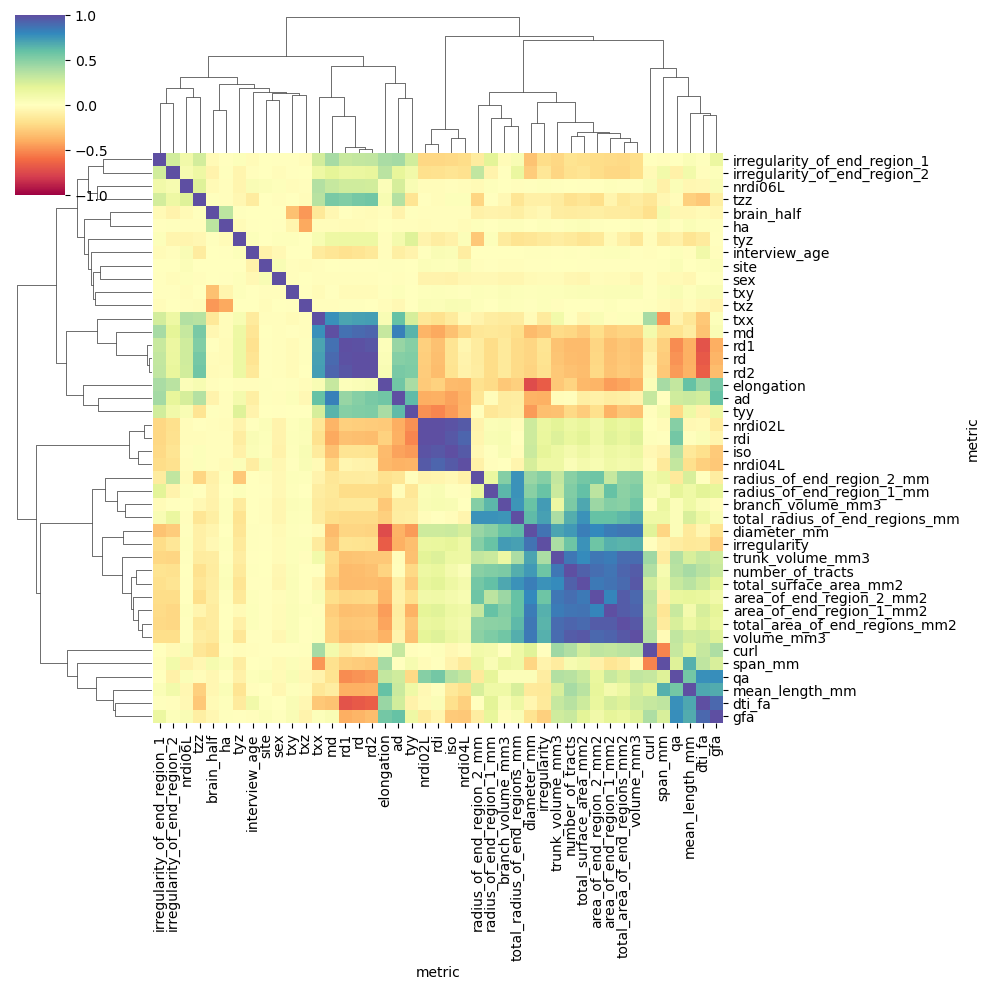

In [8]:
sns.clustermap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            vmin=-1, vmax=1,
            cmap = "Spectral")
plt.show()

Many of these relationships make sense based on the mathematical derivatives of these metrics.
* Mean length negatively corr with rd (radial diffusivity)
* Elongation (length/diameter) negatively correlated with irregularity (SA/len*diam) 
* Curl (length/span) negatively correlated with span 
* Trunk volume positively correlated with number of tracts

In [9]:
# Narrow down the metrics based on which are quite correlated to ease in viz
metrics_reduced = ['ad', 'area_of_end_region_1_mm2', 'area_of_end_region_2_mm2',
       'branch_volume_mm3', 'curl', 'diameter_mm', 'dti_fa', 'elongation',
       'gfa', 'ha', 'irregularity', 'irregularity_of_end_region_1',
       'irregularity_of_end_region_2', 'md', 'mean_length_mm',
       'nrdi06L', 'number_of_tracts', 'qa',
       'radius_of_end_region_1_mm', 'radius_of_end_region_2_mm', 'rd',
       'rdi', 'span_mm',
       'total_radius_of_end_regions_mm', 'total_surface_area_mm2',
       'trunk_volume_mm3', 'txx', 'txy', 'txz', 'tyy', 'tyz', 'tzz',
       'volume_mm3']

In [10]:
# metrics_reduced2 = ["mean_length_mm", "span_mm", "curl", "elongation", "irregularity", 
#                     "total_volume_mm3", "total_surface_area_mm2", "total_radius_of_end_regions_mm",
#                     "total_area_of_end_regions_mm2", "area_of_end_region_1_mm2", "volume_of_end_branches_1",
#                     "area_of_end_region_2_mm2", "volume_of_end_branches_2", "gfa", "dti_fa",
#                     "rd1", "rd2", "ha", "md", "ad", "rd"]

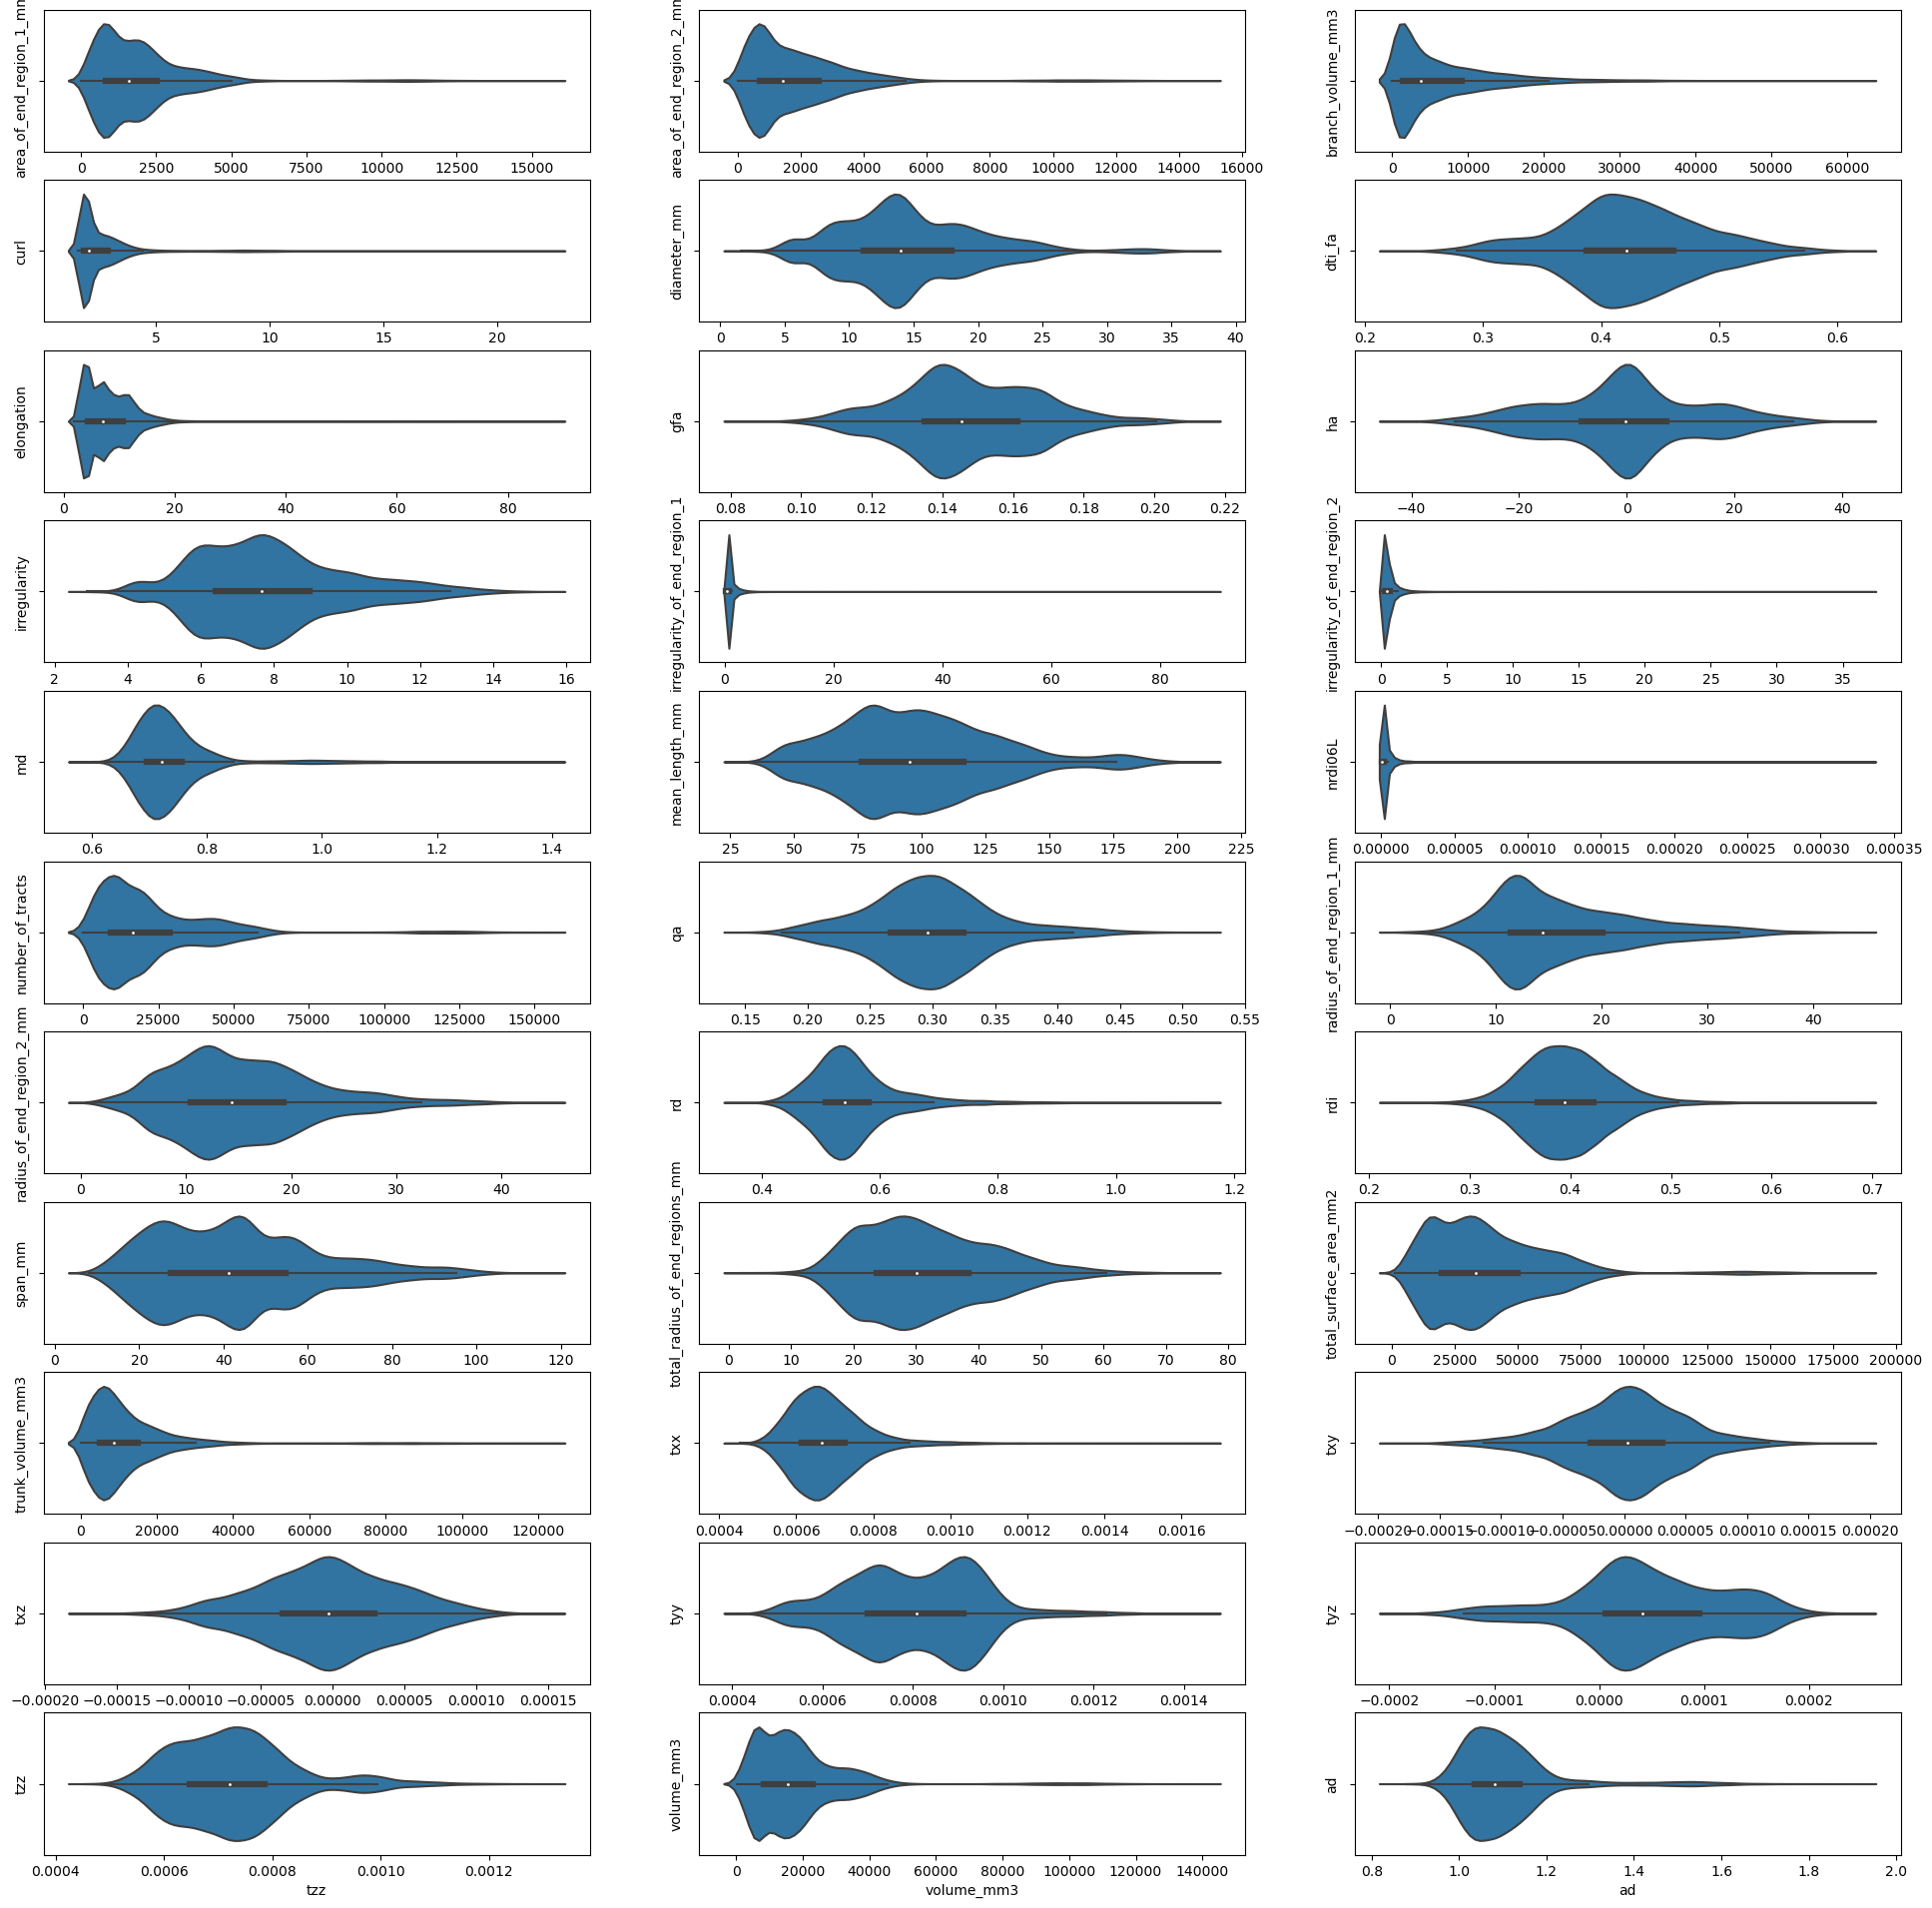

In [11]:
num_dems = 3
metrics_long["all"] = ""
num_metrics = metrics_long[metrics_reduced].columns.nunique()  
fig, axes = plt.subplots(int(num_metrics/3), 3, figsize=(24, 24))
axes = axes.flatten()

for idx, col in enumerate(metrics_long[metrics_reduced]):
    sns.violinplot(ax = axes[idx - 1], data = metrics_long, x=col, y="all")
    axes[idx - 1].set(ylabel = col)
    
plt.show()

### General stats on measures across the entire dataset

In [12]:
metrics_long[metrics_reduced].describe()

metric,ad,area_of_end_region_1_mm2,area_of_end_region_2_mm2,branch_volume_mm3,curl,diameter_mm,dti_fa,elongation,gfa,ha,...,total_radius_of_end_regions_mm,total_surface_area_mm2,trunk_volume_mm3,txx,txy,txz,tyy,tyz,tzz,volume_mm3
count,32029.000000,32029.000000,32029.000000,32029.000000,32029.000000,32029.000000,32029.000000,32029.000000,32029.000000,32029.000000,...,32029.000000,32029.000000,32029.000000,32029.000000,32029.000000,32029.000000,32029.000000,32029.000000,32029.000000,32029.000000
mean,1.104141,1950.948882,1864.834341,6307.239284,2.655820,14.730091,0.423807,7.791164,0.147366,-0.346374,...,31.544904,37559.192183,12038.194695,0.000680,0.000002,-0.000003,0.000804,0.000046,0.000729,18345.433633
std,0.113588,1686.954919,1752.578412,6798.152969,1.595585,5.382267,0.059797,4.205952,0.019468,13.725780,...,10.428821,23808.669249,12565.759140,0.000101,0.000048,0.000047,0.000144,0.000071,0.000114,15114.758240
min,0.845712,3.937500,2.250000,0.000000,1.551280,1.628100,0.226978,1.882700,0.083040,-42.516900,...,1.839820,1034.440000,0.000000,0.000438,-0.000187,-0.000172,0.000418,-0.000192,0.000452,145.969000
25%,1.034480,834.750000,704.812000,1447.450000,1.838260,11.152000,0.387765,4.281950,0.134845,-8.367270,...,23.629200,19859.100000,5005.550000,0.000615,-0.000027,-0.000034,0.000700,0.000006,0.000647,8242.590000
50%,1.082140,1589.620000,1415.810000,3746.250000,2.065140,13.980400,0.421753,7.010660,0.145419,-0.209622,...,30.075200,33157.700000,8756.860000,0.000666,0.000003,-0.000003,0.000808,0.000041,0.000720,15390.800000
75%,1.138800,2505.380000,2556.560000,9109.120000,2.872720,17.960100,0.461502,10.554500,0.161201,7.303800,...,38.352300,49838.600000,15115.800000,0.000727,0.000031,0.000029,0.000912,0.000095,0.000786,23162.600000
max,1.925070,15675.800000,14872.500000,62062.000000,22.559800,37.459700,0.617752,89.226500,0.213777,42.786800,...,76.119600,185985.000000,123773.000000,0.001676,0.000193,0.000150,0.001444,0.000246,0.001311,141601.000000


In [13]:
# TODO: split by tract, stats per tract

### Site analysis: ANOVA

In [20]:
for col in metrics_long[metrics_reduced]:
    # Fit the ANOVA model
    model = ols(col + ' ~ C(site)', data=metrics_long).fit()

    # Perform ANOVA
    anova_table = sm.stats.anova_lm(model, typ=2)
    
    if anova_table["PR(>F)"][0] < 0.05:     
        print("\n" + col + ": \n")
        print(anova_table)
    
        # Perform Tukey's HSD test
#         tukey = pairwise_tukeyhsd(endog=metrics_long[col], groups=metrics_long["site"], alpha=0.05)
#         print(tukey)


dti_fa: 

              sum_sq       df         F    PR(>F)
C(site)     0.085542      3.0  7.979589  0.000026
Residual  114.437122  32025.0       NaN       NaN

gfa: 

             sum_sq       df          F        PR(>F)
C(site)    0.018490      3.0  16.286431  1.422811e-10
Residual  12.119615  32025.0        NaN           NaN

nrdi06L: 

                sum_sq       df          F        PR(>F)
C(site)   2.161476e-09      3.0  25.202556  2.803553e-16
Residual  9.155323e-07  32025.0        NaN           NaN

qa: 

             sum_sq       df          F        PR(>F)
C(site)    0.300951      3.0  40.272156  5.756339e-26
Residual  79.773600  32025.0        NaN           NaN

rd: 

              sum_sq       df         F    PR(>F)
C(site)     0.066759      3.0  3.832025  0.009333
Residual  185.971535  32025.0       NaN       NaN

rdi: 

             sum_sq       df          F        PR(>F)
C(site)    0.237139      3.0  41.282746  1.287024e-26
Residual  61.320053  32025.0        NaN     

Association in dti_fa, gfa, nrdi06L, qa, rd, rdi, txx, txy, tyy, tzz. These are all diffusion metrics rather than shape metrics. 

In [21]:
metrics_by_tract = metrics.pivot(columns="bundle", 
                             values="score", 
                             index = ["sub", "metric", "site", 
                                      "sex", "interview_age"]).reset_index().copy()
metrics_by_tract.head(0)

bundle,sub,metric,site,sex,interview_age,ArcuateFasciculusL,ArcuateFasciculusR,CingulumFrontalParahippocampalL,CingulumFrontalParahippocampalR,CingulumFrontalParietalL,...,ThalamicRadiationAnteriorL,ThalamicRadiationAnteriorR,ThalamicRadiationPosteriorL,ThalamicRadiationPosteriorR,ThalamicRadiationSuperiorL,ThalamicRadiationSuperiorR,UncinateFasciculusL,UncinateFasciculusR,VerticalOccipitalFasciculusL,VerticalOccipitalFasciculusR


In [17]:
main_metrics = ["radius_of_end_region_1_mm",
 "radius_of_end_region_2_mm", 
 "curl", 
 "diameter_mm",
 "mean_length_mm",
 "span_mm"]

In [68]:
# metrics_long[metrics_long["tract_raw"] == 'ArcuateFasciculus']

In [67]:
with open("../../outputs/tract_stats.txt", "a") as f:
    for tract in metrics_long["tract_raw"].unique():
        print(tract + "\n", file=f)
        tract_df = metrics_long[metrics_long["tract_raw"] == tract]
        print("MEAN:" + "\n", file=f)
        print(tract_df[main_metrics].mean(), file=f)
        print("\n", file=f)
        print("STD:" + "\n", file=f)
        print(tract_df[main_metrics].std(), file=f)
        print("\n", file=f)

In [ ]:
## L v R
## Differences in any particular tract
#$ Graph showing significant p values comparing these factors distributions 

differences in distribution?

In [35]:
# for metric in main_metrics:
#     sns.displot(metrics_long, x=metric, hue="brain_half", kind="kde", multiple="stack")

In [48]:
metrics_long["tract_raw"].unique()

array(['ArcuateFasciculus', 'CingulumFrontalParahippocampal',
       'CingulumFrontalParietal', 'CingulumParahippocampal',
       'CingulumParahippocampalParietal', 'CingulumParolfactory',
       'CorpusCallosumBod', 'CorpusCallosumForcepsMajo',
       'CorpusCallosumForcepsMino', 'CorpusCallosumTapetu',
       'CorticospinalTract', 'CorticostriatalTractAnterior',
       'CorticostriatalTractPosterior', 'CorticostriatalTractSuperior',
       'Fornix', 'FrontalAslantTract',
       'InferiorFrontoOccipitalFasciculus',
       'InferiorLongitudinalFasciculus', 'MiddleLongitudinalFasciculus',
       'OpticRadiation', 'ParietalAslantTract', 'ReticularTract',
       'SuperiorLongitudinalFasciculus1',
       'SuperiorLongitudinalFasciculus2',
       'SuperiorLongitudinalFasciculus3', 'ThalamicRadiationAnterior',
       'ThalamicRadiationPosterior', 'ThalamicRadiationSuperior',
       'UncinateFasciculus', 'VerticalOccipitalFasciculus'], dtype=object)

In [60]:
def narrow_tract(tract):
    if "ArcuateFasciculus" in tract: return "AF"
    elif "Cingulum" in tract: return "C"
    elif "CorpusCallosum" in tract: return "CC"
    elif "CorticostriatalTract" in tract: return "CST"
    elif "SuperiorLongitudinalFasciculus" in tract: return "SLF"
    elif "ThalamicRadiation" in tract: return "TR"
    else: return tract

In [63]:
metrics_long["tract_narrow"] = [narrow_tract(tract) for tract in metrics_long["tract_raw"]]
metrics_long["tract_narrow"].unique()

array(['AF', 'C', 'CC', 'CorticospinalTract', 'CST', 'Fornix',
       'FrontalAslantTract', 'InferiorFrontoOccipitalFasciculus',
       'InferiorLongitudinalFasciculus', 'MiddleLongitudinalFasciculus',
       'OpticRadiation', 'ParietalAslantTract', 'ReticularTract', 'SLF',
       'TR', 'UncinateFasciculus', 'VerticalOccipitalFasciculus'],
      dtype=object)

In [66]:
# for tract in metrics_long["tract_narrow"].unique():
#     tract_df = metrics_long[metrics_long["tract_narrow"] == tract]
#     sns.displot(tract_df, x=metric, hue="brain_half", kind="kde", multiple="stack")